In [1]:
import time
start = time.time()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1638942760292_0002,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
import pyspark
import os

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%local
import pandas as pd
import plotly.graph_objects as go

In [4]:
file = 's3://millionsongs-data/new_g4g.csv'
data = sc.textFile(file)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
header = data.flatMap(lambda x: x.split('\n')).map(
    lambda x: x.split('\t')).first()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
header_dict = {head: i for i, head in enumerate(header)}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
input_rdd = data.flatMap(lambda x: x.split('\n')).map(
    lambda x: x.split('\t')).filter(lambda x: x != header)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
input_rdd.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PythonRDD[3] at RDD at PythonRDD.scala:53

In [9]:
popularity_rdd = input_rdd.map(lambda x: (x[header_dict['get_artist_name']], x[header_dict['get_artist_latitude']], x[header_dict['get_artist_longitude']],
                               x[header_dict['get_artist_hotttnesss']])).filter(lambda x: x[1] != '').map(lambda x: (x[0], float(x[1]), float(x[2]), float(x[3]))).filter(lambda x: x[3] > 0.5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
popularity_df = popularity_rdd.toDF()
popularity_df.createOrReplaceTempView('popularity_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
%%sql -o df_popularity
SELECT * FROM popularity_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

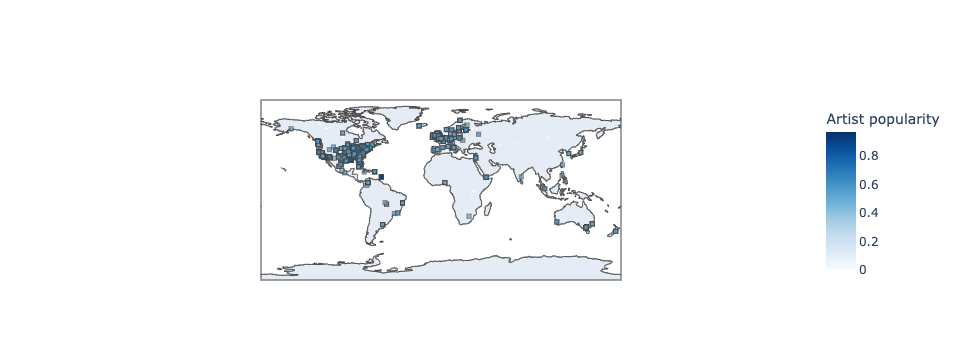

In [12]:
%%local
import plotly.graph_objects as go
fig = go.Figure(data=go.Scattergeo(
    lon=df_popularity['_3'],
    lat=df_popularity['_2'],
    text=df_popularity['_4'],
    mode='markers',
    marker=dict(
        size=4,
        opacity=0.7,
        reversescale=False,
        autocolorscale=False,
        symbol='square',
        line=dict(
                width=1,
                color='rgba(102, 102, 102)'
                ),
        colorscale='Blues',
        cmin=0,
        color=df_popularity['_4'],
        cmax=df_popularity['_4'].max(),
        colorbar_title="Artist popularity"
    )))
fig.show()

In [13]:
artist_count = input_rdd.map(lambda x: (
    x[header_dict['get_artist_name']], x[header_dict['get_artist_location']])).groupByKey().mapValues(lambda x: len(list(x)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
artist_location = input_rdd.map(lambda x: (x[header_dict['get_artist_name']], x[header_dict['get_artist_location']], float(
    x[header_dict['get_artist_hotttnesss']]))).filter(lambda x: x[2] > 0.5).distinct()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [15]:
artist_ct_loc = artist_location.join(artist_count, numPartitions=7).distinct().map(lambda x: (x[1][0], (x[0], x[1][1])))\
    .filter(lambda x: x[0] != '').map(lambda x: (x[0], 1))\
    .reduceByKey(lambda x, y: x+y).sortBy(lambda x: x[1], ascending=False, numPartitions=7)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
artist_df = artist_ct_loc.toDF()
artist_df.createOrReplaceTempView('artist_view')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
%%sql -o df_artist
SELECT * FROM artist_view limit 10

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

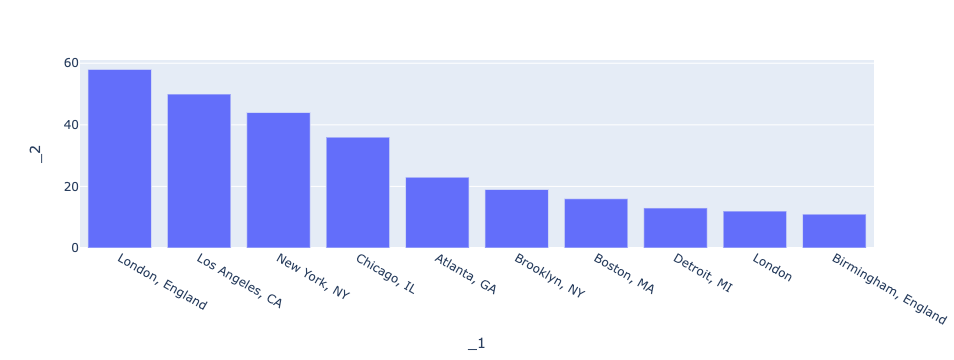

In [18]:
%%local
import plotly.express as px
fig = px.bar(df_artist, x='_1', y='_2')
fig.update_layout(
    height=400,
    title_text='  #Location count of popular artist by city',
    yaxis_title="#Number of songs",
    xaxis_title="Year"
)
fig.show()

In [19]:
stop = time.time()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
stop-start

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

49.88664126396179

In [21]:
sc.stop()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…